**<p style = "text-align: center">TRƯỜNG ĐẠI HỌC KHOA HỌC TỰ NHIÊN - ĐẠI HỌC QUỐC GIA TPHCM</p>**

# **<p style = "text-align: center">NHẬP MÔN KHOA HỌC DỮ LIỆU</p>**
## **<p style = "text-align: center">Đồ án Cuối kì</p>**
### <p style = "text-align: center"> <b>Đề tài:</b> Phân tích, khám phá dữ liệu về sách trên web thương mại điện tử (tiki)</p>
**Sinh viên thực hiện**

| Mã số sinh viên | Họ và tên |
| --- | --- |
| 20120040 | Nguyễn Quang Gia Bảo |
| 20120136 | Huỳnh Tuấn Nam |
| 20120158 | Trần Hoàng Anh Phi |

---

# **1. Thông tin về dữ liệu**<br>
Dữ liệu được sử dụng trong bài được lấy từ trang: <a href = "https://tiki.vn/sach-truyen-tieng-viet/c316"> https://tiki.vn/sach-truyen-tieng-viet/c316</a><br>

Vì website <a href = 'https://tiki.vn/'> https://tiki.vn/ </a> có khá là nhiều mặt hàng nên nhóm chỉ chọn ra danh mục <font color=red>sách tiếng Việt</font> để crawl và thực hiện đồ án này.


# **2. Khám phá dữ liệu**<br>

#### Cài đặt các thư viện cần thiết

In [267]:
# !pip install fuzzywuzzy
# !pip install python-Levenshtein

#### Import các package cần thiết

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Đọc dữ liệu đã thu thập từ file csv 

In [154]:
df = pd.read_csv('full_data/data.csv')
print(df.shape)
display(df.head())

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_29284\906639567.py:1: DtypeWarning: Columns (22,27,29,30,31,32,33,34,35,36,37,38,39,40,41,43,45,46,47,48,49,50,51,52,53,54,56,57,58,59,60,61,62,63,64,65,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('full_data/data.csv')


(96647, 84)


,Unnamed: 0,id,master_id,sku,name,short_url,book_cover,price,original_price,discount_rate,...,kich_thuoc,tai_trong,device_brand,do_nhay,tan_so,huong_dan_bao_quan,dac_diem_noi_bat,dieu_kien_su_dung,dia_chi_su_dung,bluetooth
0,0,204317934,204317934,9972713357587,1111 - Nhật Ký Sáu Vạn Dặm Trên Yên Xe Cà Tàng,https://tiki.vn/product-p204317934.html?spid=2...,NaN,262000,325000,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,205279963,205279963,7618382614299,1111 - Nhật Ký Sáu Vạn Dặm Trên Yên Xe Cà Tàng,https://tiki.vn/product-p205279963.html?spid=2...,Bìa mềm,256750,325000,21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,193209826,193209826,5001141446127,Con Đường Tơ Lụa - Vạn Dặm Xa Từ Pakistan Tới ...,https://tiki.vn/product-p193209826.html?spid=1...,Bìa mềm,95100,129000,26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,205288789,205288789,9035774965791,1111 - Nhật Ký Sáu Vạn Dặm Trên Yên Xe Cà Tàng,https://tiki.vn/product-p205288789.html?spid=2...,Bìa mềm,292500,325000,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,204649516,204649516,8708257676679,Sách - 1111 - NHẬT KÝ SÁU VẠN DẶM TRÊN YÊN XE ...,https://tiki.vn/product-p204649516.html?spid=2...,NaN,292500,325000,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96647 entries, 0 to 96646
Data columns (total 84 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    96647 non-null  int64  
 1   id                            96647 non-null  int64  
 2   master_id                     96647 non-null  int64  
 3   sku                           96647 non-null  int64  
 4   name                          96647 non-null  object 
 5   short_url                     96647 non-null  object 
 6   book_cover                    66029 non-null  object 
 7   price                         96647 non-null  int64  
 8   original_price                96647 non-null  int64  
 9   discount_rate                 96647 non-null  int64  
 10  rating_average                96647 non-null  float64
 11  review_count                  96647 non-null  int64  
 12  inventory_type                96647 non-null  object 
 13  p

***

## **Cleaning data**

Drop cột 'Unnamed: 0'

In [156]:
df = df.drop(columns='Unnamed: 0')
df.head()

,id,master_id,sku,name,short_url,book_cover,price,original_price,discount_rate,rating_average,...,kich_thuoc,tai_trong,device_brand,do_nhay,tan_so,huong_dan_bao_quan,dac_diem_noi_bat,dieu_kien_su_dung,dia_chi_su_dung,bluetooth
0,204317934,204317934,9972713357587,1111 - Nhật Ký Sáu Vạn Dặm Trên Yên Xe Cà Tàng,https://tiki.vn/product-p204317934.html?spid=2...,NaN,262000,325000,19,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,205279963,205279963,7618382614299,1111 - Nhật Ký Sáu Vạn Dặm Trên Yên Xe Cà Tàng,https://tiki.vn/product-p205279963.html?spid=2...,Bìa mềm,256750,325000,21,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,193209826,193209826,5001141446127,Con Đường Tơ Lụa - Vạn Dặm Xa Từ Pakistan Tới ...,https://tiki.vn/product-p193209826.html?spid=1...,Bìa mềm,95100,129000,26,4.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,205288789,205288789,9035774965791,1111 - Nhật Ký Sáu Vạn Dặm Trên Yên Xe Cà Tàng,https://tiki.vn/product-p205288789.html?spid=2...,Bìa mềm,292500,325000,10,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,204649516,204649516,8708257676679,Sách - 1111 - NHẬT KÝ SÁU VẠN DẶM TRÊN YÊN XE ...,https://tiki.vn/product-p204649516.html?spid=2...,NaN,292500,325000,10,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Xem thử dữ liệu có bị trùng hay không?

In [157]:
df.duplicated().sum()

8294

Vậy là dữ liệu có 8294 dòng trùng nhau, ta sẽ tiến hành xoá những dòng này

In [158]:
df = df.drop_duplicates(ignore_index=True)
df.shape

(88353, 83)

#### **Mỗi dòng có ý nghĩa gì? Có các dòng có ý nghĩa khác nhau hay không?**

Mỗi dòng cho biết thông tin về một sản phẩm sách.

Vì khi thu thập dữ liệu, có những sản phẩm khác loại bị tiki xếp vào chung danh mục nên ta thấy những columns lạ bị thêm vào, ta phải tiến hành xoá những columns này và những sản phẩm (dòng) <font color =red>lạc loài </font>

In [159]:
df.columns

Index(['id', 'master_id', 'sku', 'name', 'short_url', 'book_cover', 'price',
       'original_price', 'discount_rate', 'rating_average', 'review_count',
       'inventory_type', 'productset_group_name', 'day_ago_created',
       'categories', 'all_time_quantity_sold', 'authors', 'publisher_vn',
       'publication_date', 'dimensions', 'manufacturer', 'number_of_page',
       'dich_gia', 'edition', 'brand', 'brand_country', 'item_model_number',
       'origin', 'product_weight', 'battery_capacity', 'camera', 'chong_nuoc',
       'loai_day', 'san_pham', 'storage', 'battery_life', 'charge_time',
       'do_chiu_nuoc', 'included_accessories', 'material', 'luu_y',
       'minimum_inbound_policy_days', 'expiry_time', 'shelf_life_days',
       'chat_lieu', 'audio_power_output', 'audio_technology',
       'dieu_khien_bang_giong_noi', 'dieu_khien_tivi', 'digital_tivi_dvb_t2',
       'display_type', 'frequency', 'hdh_giao_dien',
       'image_processing_technology', 'network_hdmi', 'network_inte

In [160]:
df[~df['material'].isna()]

,id,master_id,sku,name,short_url,book_cover,price,original_price,discount_rate,rating_average,...,kich_thuoc,tai_trong,device_brand,do_nhay,tan_so,huong_dan_bao_quan,dac_diem_noi_bat,dieu_kien_su_dung,dia_chi_su_dung,bluetooth
13233,144356210,144356210,5525114755464,"Túi đeo chạy bộ, túi đeo hông, đeo bụng dành c...",https://tiki.vn/product-p144356210.html?spid=1...,NaN,112000,139000,19,4.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14886,207035527,207035527,6816910771280,Áo Hoodie Nỉ Ngoại Nữ Thêu Chữ Loang Màu Hồng ...,https://tiki.vn/product-p207035527.html?spid=2...,NaN,109000,109000,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15160,176689612,176689612,9588934896842,Vỏ gối trắng trơn-vỏ gối cao cấp 100% Cotton-t...,https://tiki.vn/product-p176689612.html?spid=1...,NaN,63750,63750,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25077,207631100,207631100,6801021851103,Áo Khoác Nam Nữ Xanh Rêu Áo Khoác Dù Dáng Rộng,https://tiki.vn/product-p207631100.html?spid=2...,NaN,130000,130000,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49830,196565537,196565537,5928507424911,"Rèm Tự Dính-Không Cần Khoan Vô Cùng Tiện Lợi, ...",https://tiki.vn/product-p196565537.html?spid=1...,NaN,52500,105000,50,0.0,...,30 x 20 x 5,5kg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63694,202432845,202432845,8183965466103,BBSTORE'S Đầm Xòe Dự Tiệc Tay Phồng Thời Trang...,https://tiki.vn/product-p202432845.html?spid=2...,NaN,219000,219000,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76899,175150080,175150080,9992881446659,"Bộ Bàn Ghế Gỗ Me Tây Nguyên Khối, Bàn Ghế Ăn G...",https://tiki.vn/product-p175150080.html?spid=1...,NaN,20400000,20400000,0,0.0,...,"3,39 x (70 - 75) x 5",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Các `features` được sử dụng

In [161]:
features = ['id', 'master_id', 'sku', 'name', 'short_url', 'book_cover', 'price',
       'original_price', 'discount_rate', 'rating_average', 'review_count',
       'inventory_type', 'productset_group_name', 'day_ago_created',
       'categories', 'all_time_quantity_sold', 'authors', 'publisher_vn',
       'publication_date', 'dimensions', 'manufacturer', 'number_of_page',
       'dich_gia', 'edition', 'luu_y']

Một số `features` không hợp lệ với yêu cầu bài toán

In [162]:
unvalid_cols = list(set(df.columns) - set(features))
print(unvalid_cols)

['weight_with_stand', 'brand', 'dieu_khien_tivi', 'bluetooth', 'size_with_stand_table_top', 'camera', 'loai_pin', 'weight_without_stand', 'charge_time', 'thoi_gian_su_dung', 'battery_life', 'dac_diem_noi_bat', 'ung_dung', 'network_hdmi', 'origin', 'material', 'size_without_stand_table_top', 'huong_dan_bao_quan', 'hdh_giao_dien', 'loai_day', 'kich_thuoc', 'audio_power_output', 'remote_thong_minh', 'audio_technology', 'resolution', 'frequency', 'display_type', 'huong_dan_su_dung', 'shelf_life_days', 'usb', 'tivi_type', 'do_chiu_nuoc', 'dia_chi_su_dung', 'product_weight', 'included_accessories', 'chong_nuoc', 'size', 'screen_mirroring', 'tan_so', 'do_nhay', 'dieu_khien_bang_giong_noi', 'device_brand', 'network_internet', 'tai_trong', 'san_pham', 'battery_capacity', 'brand_country', 'image_processing_technology', 'dieu_kien_su_dung', 'chat_lieu', 'network_wifi', 'capacity', 'minimum_inbound_policy_days', 'screen_size', 'expiry_time', 'item_model_number', 'storage', 'digital_tivi_dvb_t2']


Thử lấy các sản phẩm thuộc ngoài những `categories` của danh mục sách (mà ta đã thu thập)

In [163]:
valid_categories = pd.read_csv('id_data/categories_id.csv')['categories'] 
valid_categories = '|'.join(list(valid_categories)) #+ ['Root', 'Sách tiếng Việt', 'Nhà Sách Tiki'])
# df[df[unvalid_cols].notna().any(axis=1)].to_csv('not_books.csv', encoding='utf-8-sig')
# df[df['publisher_vn'].isna()].to_csv('not_publiser.csv', encoding='utf-8-sig')
# df[df['categories'].str.contains(valid_categories, na=False)]

#Chọn những categories không phải sách
df[~df['categories'].str.contains(valid_categories, na=False)]['categories'].value_counts()

Root                                   20440
Sách tiếng Việt                        19201
Nhà Sách Tiki                             23
Máy Ảnh - Máy Quay Phim                    4
Túi và Hộp Đựng Máy Ảnh                    3
Thiết Bị Số - Phụ Kiện Số                  3
Tai Nghe True Wireless                     2
Đầu Ghi Hình Camera                        1
Nước Ngọt                                  1
Móng giả                                   1
Bộ sản phẩm vệ sinh nhà cửa                1
Làm Đẹp - Sức Khỏe                         1
Thực phẩm khô khác                         1
Loa Vi Tính                                1
Dây Đeo Máy Ảnh, Máy Quay, Ống Nhòm        1
Bình, ly uống trà và phụ kiện              1
Voucher - Dịch vụ                          1
Bàn ghế làm việc                           1
Nón bơi                                    1
Phụ Kiện Máy Quay Khác                     1
Bao Da - Ốp Lưng iPad                      1
Bình đun siêu tốc                          1
Các loại g

Và ta chỉ lấy những giá trị hợp lệ 

In [164]:
df = df[df['categories'].str.contains(valid_categories, na=False)]
# df.shape
df.shape

(48291, 83)

Có thể vẫn còn, ta sẽ xem những features bị <font color=red>lạc loài</font> (khác giá trị nan):

In [165]:
unvalid_products = df[df[unvalid_cols].notna().any(axis=1)]
# display(unvalid_products)

Tiếp tục bỏ đi những sản phẩm này.

In [166]:
df = df.drop(unvalid_products.index).reset_index(drop=True)
df[df[unvalid_cols].notna().any(axis=1)] # test lại

,id,master_id,sku,name,short_url,book_cover,price,original_price,discount_rate,rating_average,...,kich_thuoc,tai_trong,device_brand,do_nhay,tan_so,huong_dan_bao_quan,dac_diem_noi_bat,dieu_kien_su_dung,dia_chi_su_dung,bluetooth


In [167]:
df.index.max()

48290

Có thể vẫn còn những sản phẩm <font color=red>lạc loài</font> khác, tuy nhiên khó có thể nhận biết và loại bỏ được.

Xóa đi các cột <font color =red> lạc loài </font> đi thôi!

In [168]:
df = df.drop(unvalid_cols, axis = 1)
df.shape

(48291, 25)

##### Kiểm tra lại thông tin của các cột trước khi bước qua **KHÁM PHÁ DỮ LIỆU**

> Mô tả thông tin của các cột


In [169]:
pd.read_csv("column/Columns.csv")

,Name,Type,Describe
0,id,string,ID của quyền sách
1,sku,string,Mã hàng hóa
2,name,string,Tên quyển sách
3,short_url,string,Đường link đến trang bán sách
4,book_cover,string,Loại bìa sách
5,price,int,Giá quyển sách đang được bán trên tiki
6,original_price,int,Giá gốc của quyển sách
7,discount_rate,int,% Giảm giá
8,rating_average,float,Mức đánh giát trung bình ( 0 <= x <= 5)
9,review_count,int,"Số lượt đánh giá, bình luận của khách hàng"


Cột `id` và `master_id` hoàn toàn giống nhau ở từng dòng. Vì thế ta sẽ xóa đi cột `master_id` <br>
Cột `publication_date` cần thay đổi `dtype` thành `datetime`

- Loại bỏ cột `master_id`

In [170]:
df = df.drop("master_id", axis = 1)

- Xem thông tin kiểu dữ liệu của mỗi cột

In [171]:
df.dtypes

id                          int64
sku                         int64
name                       object
short_url                  object
book_cover                 object
price                       int64
original_price              int64
discount_rate               int64
rating_average            float64
review_count                int64
inventory_type             object
productset_group_name      object
day_ago_created             int64
categories                 object
all_time_quantity_sold      int64
authors                    object
publisher_vn               object
publication_date           object
dimensions                 object
manufacturer               object
number_of_page             object
dich_gia                   object
edition                    object
luu_y                      object
dtype: object

Ta thấy cột `number_of_page` có kiểu dữ liệu là object chưa phù hợp (lẽ ra phải là interger), ta sẽ chuyển về đúng kiểu dữ liệu

In [172]:
# df['number_of_page'].fillna(0).astype(np.int64)
# df['number_of_page'].unique()
set(df['number_of_page'].apply(lambda x: type(x)))

{float, str}

Cột này chứa 2 kiểu dữ liệu là `str` (?) và `float`:
- Tại sao lại chứa kiểu dữ liệu string?

In [173]:
df[df['number_of_page'].apply(lambda x: isinstance(x, str))]['number_of_page'].unique()

array(['336', '178', '216', ..., '10512', '1058', '879'], dtype=object)

In [174]:
df[df['number_of_page'].str.contains(r'[a-zA-Z]', na=False)]['number_of_page'].unique()

array(['Cuốn', '80x2', 'mềm'], dtype=object)

- Thì ra các giá trị `integer` đã bị chuyển thành string.
- Một vài giá trị string <font color=red>lạc loài</font> ("Cuốn", "80x2", "mềm") đã làm kiểu dữ liệu bị thay đổi. Ta sẽ chuyển các giá trị này về nan.

In [175]:
df.loc[df['number_of_page'].str.contains(r'[a-zA-Z]', na=False), 'number_of_page'] = np.nan

In [176]:
df['number_of_page'] = df['number_of_page'].fillna(0).astype(np.int64)
df['number_of_page'].dtype

dtype('int64')

Đổi dtype của cột `publication_date` thành datetime

In [177]:
df.publication_date = pd.to_datetime(df.publication_date, format = "%Y-%m-%d %H:%M:%S", errors = "coerce")

Gần hơn 1 nửa dữ liệu bị lỗi hoặc thiếu datetime.

**Save dữ liệu đã xử lý để phục vụ cho việc xây dựng mô hình**

In [178]:
import os
os.mkdir('./features')
df.to_csv('./features/processed.csv',index=False, encoding='utf-8-sig')

---

#### **Exploratory Data Analysis**

##### **Đặt câu hỏi** <br>
Một câu hỏi gồm có 3 ý:
- Câu hỏi là gì ?
- Trả lời câu hỏi sẽ có lợi ích gì ?
- Nguồn cảm hứng của câu hỏi ? (tự nghĩ hoặc tham khảo)

In [179]:
df.columns

Index(['id', 'sku', 'name', 'short_url', 'book_cover', 'price',
       'original_price', 'discount_rate', 'rating_average', 'review_count',
       'inventory_type', 'productset_group_name', 'day_ago_created',
       'categories', 'all_time_quantity_sold', 'authors', 'publisher_vn',
       'publication_date', 'dimensions', 'manufacturer', 'number_of_page',
       'dich_gia', 'edition', 'luu_y'],
      dtype='object')

---

### **Câu 1: Tại sao có những quyển sách trùng tên ?**
- Ở mỗi thể loại sách có rất nhiều sách khác nhau. Có nhiều sách cùng tên với nhau hay không? Tại sao lại như vậy?


**Trả lời câu hỏi thành công** <br>
Nếu trả lời được câu hỏi bạn sẽ hiểu tại sao trong bộ dữ liệu lại có nhiều sách có cùng tên (Nếu có)<br>


<font color = red>Khó khăn </font>: 
+ Tên của những quyển sách lại được đặt khác nhau. Ảnh hưởng đến quá trình gom nhóm. Cần xử lí vấn đề khó này cho một bộ dữ liệu gần 40 ngàn dữ liệu.<br>
+ Không có các yếu tố để phân biệt tên của sách.

<font color = red>Hướng giải quyết </font>: 
+ Thay vì xử lí một lúc 40 ngàn dữ liệu, ta sẽ sử dụng cột `categories` để phân loại thành từng loại sách, rồi tiếp tục phân loại theo tên.
+ Ta sử dụng `Ratio Matching` - Độ tương thích của 2 string, để phán đoán series của cuốn truyện.

Dùng thử viện `fuzzywuzzy` để tìm mức độ tương thích, lọc ra các nhóm có mức độ tương thích cao.

In [180]:
from fuzzywuzzy import fuzz, process

##### Viết các hàm xử lí 

 - Hàm lấy các dòng thuộc `categories` mà ta yêu cầu.

In [181]:
def get_df_by_categories(categories):
    categories_book_df = df[df.categories == categories]
    return categories_book_df

- Sử dụng Data Frame mà ta vừa lấy được từ `categories` mà ta chọn, tiến hành phân theo mức độ tương thích của các tên với nhau.


Ví dụ sử dụng fuzzywuzzy để đánh giá mức tương thích:

In [182]:
# Ta có 2 string:
a = "Xin Cảm ơn"
b = "Xin Chào"

fuzz.ratio(a,b) # Độ giống nhau là 48%
# Độ tương thích này được xét theo các yếu tố như:
# Số lượng từ ở trong hai câu
# Vị trí từ
# Kiểu viết của chữ (hoa hoặc thường)
# .....

56

In [183]:
a = "Xin Cảm ơn"
b = "Xin Chào"

fuzz.partial_ratio(a ,b) # có bao nhiêu % của a trong b hoặc b trong a, dù đổi vị trí các parameter cũng không làm thay đổi giá trị %.
# Ở câu này do vị trí của từ Xin C

62

- Viết hàm phân nhóm theo series của các sách trong 1 categories.<br>
<br>

<font color = red>Cách làm </font>:<br>
- Ta sẽ kiểm tra có 1 `list` để chứa các series và sẽ dùng `list` này để đi so sánh với tên của các cuốn sách khác.
- So sánh cuốn sách với từng series bên trong list. Nếu độ tương thích dưới 80% sẽ add tên đó vào series. Ngược lại ta sẽ thêm vào thì ta không thêm vào.
- Với mỗi series trong list sẽ được đánh dấu 1 index, ta gọi hàm index của list để lấy index đó và gán cho dòng của cuốn sách đó.<br>

<font color = red>Hàm trả về</font>: Hàm trả về list là index của series mà cuốn sách thuộc về

In [184]:
# ulen_names = lightnovel_df.name.nunique() # number of unique names
# u_names = list(map(lambda x: x.upper(), lightnovel_df.name.unique())) #array unique names


# ln_series = []
# series_Series = []
# ln_series.append(u_names[0])
# for name in u_names:
#     ratio_series = []
#     for series in ln_series:
#         ratio_series.append(SequenceMatcher(None, series, name).ratio())
#     max_ratio = max(ratio_series)
#     if max_ratio < 0.6:
#         ln_series.append(name)
#         series_Series.append(ln_series.index(name))
#     else:
#         series_Series.append(ratio_series.index(max_ratio))
def categorical_book_name(book_df):
    u_names = list(map(lambda x: x.upper(), list(book_df.name)))
    book_series = []
    series = []
    book_series.append(u_names[0])
    for name in u_names:
        ratio_series = process.extract(name, book_series, scorer = fuzz.token_sort_ratio)
        best_ratio_series = ratio_series[0]
        if best_ratio_series[-1] < 65: # Xét tỉ lệ hợp lệ cao hơn 80%
            book_series.append(name)
            series.append(book_series.index(name))
        else:
            series.append(book_series.index(best_ratio_series[0]))
    return series

Tên các loại sách

In [185]:
list(df.categories.unique())

['Du ký',
 'Light novel',
 'Phê Bình - Lý Luận Văn Học',
 'Phóng sự - Ký sự - Bút ký',
 'Tác phẩm kinh điển',
 'Thơ',
 'Tiểu sử - Hồi ký',
 'Tiểu Thuyết',
 'Truyện Giả tưởng - Huyền Bí - Phiêu Lưu',
 'Tranh Truyện',
 'Truyện cổ tích - Ngụ ngôn',
 'Truyện cười',
 'Truyện dài',
 'Bài học kinh doanh',
 'Truyện đam mỹ',
 'Truyện kiếm hiệp',
 'Truyện kinh dị',
 'Truyện ngắn - Tản văn - Tạp Văn',
 'Truyện ngôn tình',
 'Truyện trinh thám',
 'Ca dao - Tục ngữ',
 'Sách ảnh',
 'Sách doanh nhân',
 'Sách khởi nghiệp',
 'Sách kinh tế học',
 'Sách kỹ năng làm việc',
 'Sách Marketing - Bán hàng ',
 'Sách quản trị, lãnh đạo',
 'Sách quản trị nhân lực',
 'Sách tài chính, kế toán',
 'Sách tài chính, tiền tệ',
 'Đạo đức - Kỹ năng sống',
 'Kiến thức - Bách khoa',
 'Tô màu - Luyện chữ  ',
 'Truyện cổ tích',
 'Truyện kể cho bé',
 'Truyện tranh Ehon',
 'Truyện tranh thiếu nhi',
 'Văn học thiếu nhi',
 'Sách tư duy - Kỹ năng sống',
 'Sách nghệ thuật sống đẹp',
 'Sách hướng nghiệp - Kỹ năng mềm',
 'Sách Thai Gi

Thử với loại sách là `Light Novel`

**Bước 1** : Chọn loại sách `Light Novel` để thực hiện thống kê 

In [186]:
lightnovel_df = get_df_by_categories("Light novel")
# list(lightnovel_df.name)

**Bước 2**: Tiến hành phân loại theo tên sách

In [187]:
series = categorical_book_name(lightnovel_df)

In [188]:
# series = pd.DataFrame({"Series": list(categoricate_book_name(lightnovel_df))})

**Bước 3**: Thêm cột `Series` sau khi phân loại 

In [189]:
lightnovel_df.insert(len(lightnovel_df.columns), "Series", series)
# lightnovel_df = pd.concat([lightnovel_df, series], axis = 1 ,ignore_index=True)

In [190]:
lightnovel_df[lightnovel_df.Series == 0]

,id,sku,name,short_url,book_cover,price,original_price,discount_rate,rating_average,review_count,...,authors,publisher_vn,publication_date,dimensions,manufacturer,number_of_page,dich_gia,edition,luu_y,Series
102,203957932,4966276852148,Chào Mừng Đến Lớp Học Đề Cao Thực Lực - 4,https://tiki.vn/product-p203957932.html?spid=2...,Bìa mềm,95900,120000,20,5.0,25,...,Kinugasa Syougo,IPM,2022-11-11,13x18 cm,Nhà Xuất Bản Hà Nội,356,Thu Hằng,NaN,NaN,0
121,195969669,9063209978122,Chào Mừng Đến Lớp Học Đề Cao Thực Lực - 3,https://tiki.vn/product-p195969669.html?spid=1...,Bìa mềm,95900,120000,20,4.8,142,...,Kinugasa Syougo,IPM,2022-08-08,18x23 cm,Nhà Xuất Bản Hà Nội,380,Hoàng Ngọc,NaN,NaN,0


Thử loại sách `Du ký`

In [191]:
duky_df = get_df_by_categories("Du ký")

In [192]:
series = categorical_book_name(duky_df)
series

[0,
 0,
 1,
 0,
 0,
 2,
 3,
 4,
 5,
 6,
 0,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 14,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 15,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 15,
 41,
 15,
 42,
 43,
 37,
 44,
 45,
 46,
 25,
 47,
 48,
 4,
 46,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 37,
 58,
 59,
 60,
 61,
 62,
 60,
 63,
 46,
 64,
 62,
 57,
 65,
 66,
 23,
 67,
 68,
 69,
 70,
 23,
 71,
 72,
 37,
 37,
 37,
 37,
 73,
 74,
 75,
 76,
 77,
 74]

In [193]:
duky_df.insert(len(duky_df.columns), "Series", series)

In [194]:
duky_df[duky_df.Series == 0]
# duky_df[duky_df.authors == "Trần Đặng Đăng Khoa"]

,id,sku,name,short_url,book_cover,price,original_price,discount_rate,rating_average,review_count,...,authors,publisher_vn,publication_date,dimensions,manufacturer,number_of_page,dich_gia,edition,luu_y,Series
0,204317934,9972713357587,1111 - Nhật Ký Sáu Vạn Dặm Trên Yên Xe Cà Tàng,https://tiki.vn/product-p204317934.html?spid=2...,NaN,262000,325000,19,5.0,55,...,Trần Đặng Đăng Khoa,NXB Trẻ,2022-11-10 00:00:00,13 x 20,NXB Trẻ,0,NaN,NaN,NaN,0
1,205279963,7618382614299,1111 - Nhật Ký Sáu Vạn Dặm Trên Yên Xe Cà Tàng,https://tiki.vn/product-p205279963.html?spid=2...,Bìa mềm,256750,325000,21,0.0,0,...,Trần Đặng Đăng Khoa,NXB Trẻ,2022-11-11 17:44:46,NaN,NXB Trẻ,778,NaN,NaN,NaN,0
3,205288789,9035774965791,1111 - Nhật Ký Sáu Vạn Dặm Trên Yên Xe Cà Tàng,https://tiki.vn/product-p205288789.html?spid=2...,Bìa mềm,292500,325000,10,0.0,0,...,Trần Đặng Đăng Khoa,Văn Lang,2022-11-10 20:17:06,NaN,Nhà Xuất Bản Hồng Đức,776,NaN,NaN,NaN,0
4,204649516,8708257676679,Sách - 1111 - NHẬT KÝ SÁU VẠN DẶM TRÊN YÊN XE ...,https://tiki.vn/product-p204649516.html?spid=2...,NaN,292500,325000,10,0.0,0,...,NaN,NXB Trẻ,NaT,NaN,NXB Trẻ,0,NaN,NaN,NaN,0
10,205293454,4751431039506,1111 - Nhật Ký Sáu Vạn Dặm Trên Yên Xe Cà Tàng,https://tiki.vn/product-p205293454.html?spid=2...,Bìa mềm,256750,325000,21,0.0,0,...,Trần Đặng Đăng Khoa,NXB Trẻ,2022-11-11 00:34:17,NaN,NXB Trẻ,778,NaN,NaN,NaN,0


Tuy cùng là một cuốn sách, nhưng có nhiều shop khác nhau bán, có mức độ đánh giá trung bình, review của khách hàng, mức khuyến mãi, giá cả khác nhau... dẫn đến việc lựa chọn nên mua ở shop nào.

**Nhược điểm**: Như ban đầu đã báo cáo: việc thực hiện này sẽ xảy ra một số lỗi, nó không chính xác 100% vì có một số quyển sách xuất hiện các từ giống nhau, nhưng được đặt ở một vị trí khác nhau. Nhưng do sử dụng `token_sort` của `fuzz` nên độ tương thích vẫn có khả năng cao.<br>

**Về mặt ổn định của thuật toán**: Vẫn ổn đối với phần lớn dữ liệu

---

### **Câu 2 Lượt đánh giá trung bình quá ít có ảnh hưởng như thế nào?**

- `rating-average` (Mức độ đánh giá trung bình), `original_price` (Giá gốc sản phẩm), `all_time_quanity_sold` (số lượng sản phẩm bán ra), `review_count` (số lượt bình luật về món hàng) có liên quan gì đến nhau ?

- Ở câu 1 đã cho biết, có các sản phẩm cùng tên nhưng shop khác nhau, dự đoán lí do tại sao có shop bán được nhiều hàng, có shop bán không được nhiều mấy?

**Trả lời câu hỏi thành công:** <br>
Sẽ hiểu được việc đánh giá của khách hàng sẽ có ảnh hưởng như thế nào đến việc bán sản phẩm của shop.<br>

In [195]:
cols_work = ["rating_average", "categories", "price", "original_price" ,"all_time_quantity_sold", "review_count"]
rcp_df = df[cols_work]

In [196]:
# rcp_df.corr()

**Bước 1**: Phân bố `rating_average` theo các khoảng như mô tả

In [197]:
# len(df[df.rating_average >= 0])
# rcp_df.shape

In [198]:
import math
%matplotlib inline

Tạo ra một khoảng mức rating: <br>
**(0,0)** ứng với 0 sao <br>
**(0,1)** ứng với (0,1) <br>
**(1,2)** ứng với [1,2) <br>
**(2,3)** ứng với [2,3) <br>
**(3,4)** ứng với [3,4) <br>
**(4,5)** ứng với [4,5) <br>
**(5,5)** ứng với 5 sao <br>



In [199]:
def rating_range(x):
    if (x == 0.0):
        return (0,0)
    elif (x == 5.0):
        return (5,5)
    else:
        return (math.floor(x), math.floor(x+1))

In [200]:
rating_range_series = pd.DataFrame({"rating_range": rcp_df.rating_average.apply(rating_range)})
rcp_df = pd.concat([rcp_df, rating_range_series], axis = 1)
# rcp.set_axis([*df.columns[:-1], 'Test'], axis=1, inplace=False)


**Bước 2**: Trực quan hóa dữ thông tin lên đồ thị để quan sát dễ dàng.

In [201]:
def pie_chart(x,y, title):
    c = ['lightcoral', 'rosybrown', 'sandybrown', 'navajowhite', 'gold',
            'khaki', 'lightskyblue', 'turquoise', 'lightslategrey', 'thistle', 'pink']
    plt.figure(figsize=(7,5))
    plt.title(title, size=10)
#     plt.pie(rcp_df.rating_range.value_counts().sort_index().values, colors=c,shadow=True)
    plt.pie(y, colors=c,shadow=True)
#     plt.legend(rcp_df.rating_range.value_counts().sort_index().index, loc='best', fontsize=12)
    plt.legend(x, loc='best', fontsize=12)

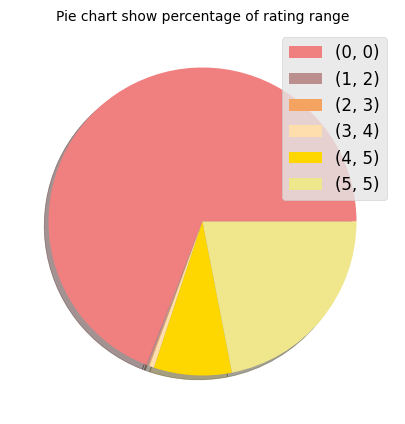

In [202]:
x = rcp_df.rating_range.value_counts().sort_index().index
y = rcp_df.rating_range.value_counts().sort_index().values
pie_chart(x, y, "Pie chart show percentage of rating range")

Qua biểu đồ trên, nhận thấy các đánh giá của khách hàng về sản phẩm không nhiều. Vẫn có nhiều mặt hàng được đánh giá là 0 sao.<br>
##### Xem thử mối quan hệ giữa `rating_range`, `original_price`, `all_time_quantity_sold`

In [265]:
def build_scatterplot(data, x, y, hue: None, ax, title):
    sns.scatterplot(data = data, x = x, y = y, ax = ax)
    ax.title.set_text(title)

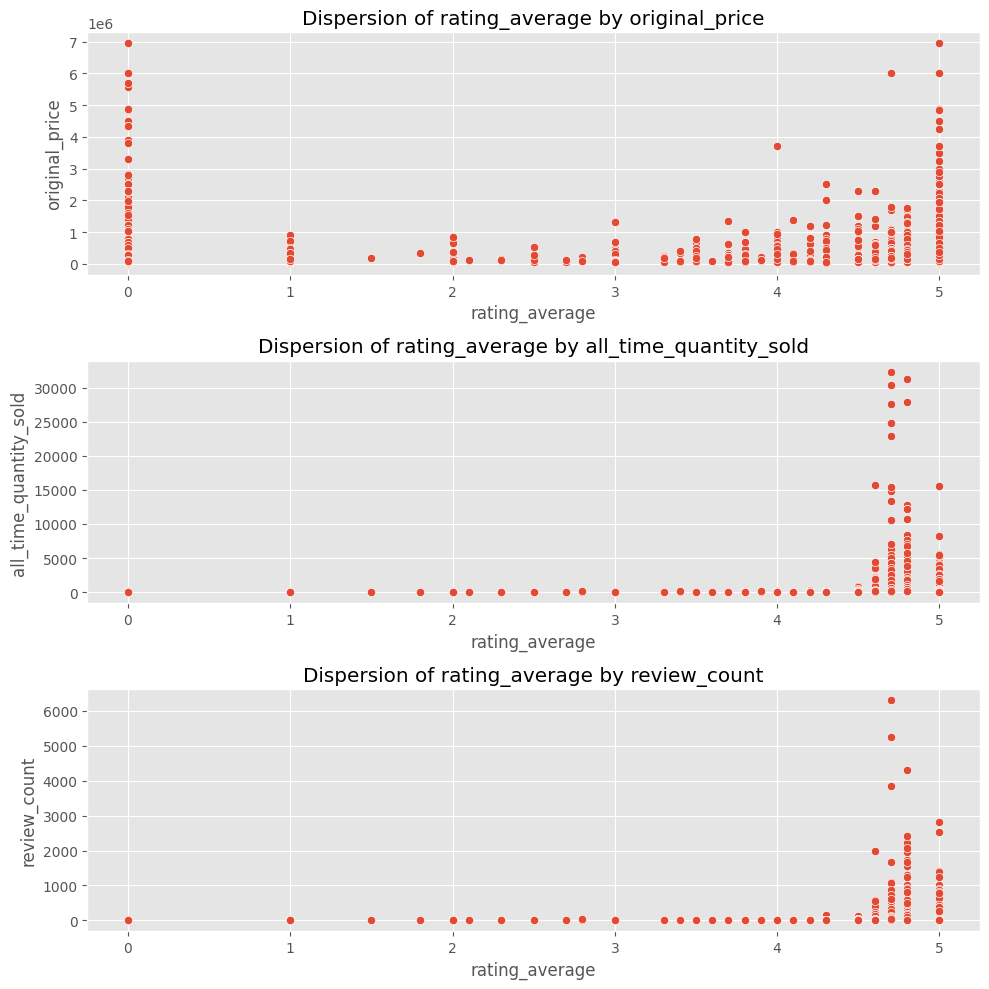

In [266]:
fig, axs = plt.subplots(3,1, figsize = (10,10))
build_scatterplot(rcp_df, x = "rating_average", y = "original_price", ax=axs[0], title = "Dispersion of rating_average by original_price", hue = None)
build_scatterplot(rcp_df, x = "rating_average", y = "all_time_quantity_sold", ax=axs[1], title = "Dispersion of rating_average by all_time_quantity_sold", hue = None)
build_scatterplot(rcp_df, x = "rating_average", y = "review_count", ax=axs[2], title = "Dispersion of rating_average by review_count", hue = None)
plt.tight_layout()

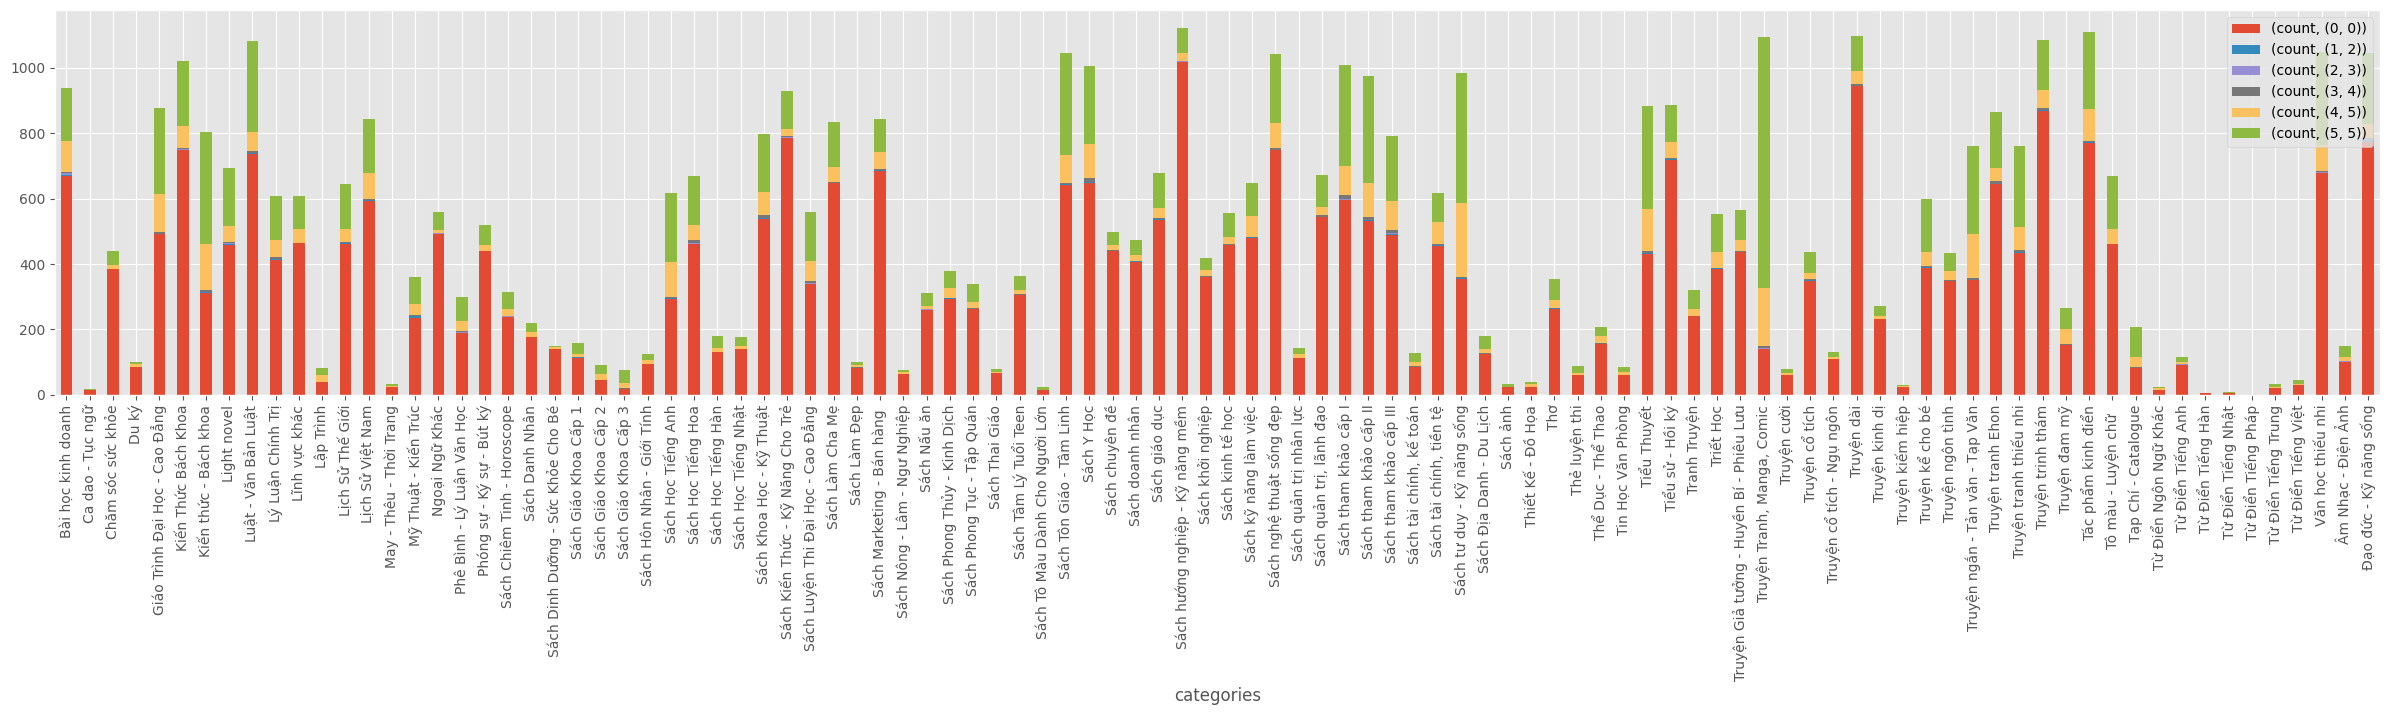

In [260]:
temp_df = rcp_df.copy()
group_df = temp_df.groupby("categories")["rating_range"].value_counts().to_frame().rename(columns = {"rating_range" : "count"}).sort_values(by = "rating_range").unstack(level = 1)
# group_df
fig, ax = plt.subplots(figsize = (30, 5))
# sns.countplot(data = group_df, x = "categories" , hue = "rating_range")
group_df.plot(kind = "bar", stacked = True, ax = ax)
plt.legend(loc = "upper right")
plt.xticks(rotation=90)
plt.show()

**Dự đoán lý do**<br>

Với đồ thị theo giá gốc của các quyển sách, hầu như tất cả giá trị đều trong vùng từ 0 đến 300 ngàn đồng là chủ yếu. Tuy nhiên với độ đánh giá là `0 sao`, hầu như số lượt mua hàng xấp xỉ hoặc hoàn toàn là 0 mặc dù sách ở mức đánh giá `0 sao` có tương đối nhiều sách được bán <br>
<br>
Việc có thể có được mức đánh giá trung bình cao nhưng lại khá ít đơn đặt hàng, theo em dự đoán rằng:<br>
+ Việc mua hàng đối với các khách hàng đầu tiên đã xảy ra 1 vài trục trặc (như hư hỏng, không đúng như trong mô tả sản phẩm,...), dẫn tới sự kém tin tưởng của shop, nên dẫn đến mức đánh giá trung bình ngày một thấp đi. Số khách hàng đến sau dựa vào 1 số bình luận, số lượt đánh giá có trên tiki đưa ra quyết định mua hàng của mình.<br>

+ Các quyển sách `0 sao` không được khách hàng tìm nhiều, hoặc không quá nổi tiếng, hoặc không cần thiết nên không có được nhiều lượt đánh giá và bình luận.

+ Ngoài ra, thông tin được tìm kiếm ở câu 1, có một số cuốn sách bị trùng tên nhưng có nhiều shop bán. Việc một shop đầy sự tin tưởng trong suốt quá trình bán online trên tiki, dẫn đến việc khách hàng cũ sẽ ưu tiên mua sách ở shop quen thuộc hơn là mua ở một shop có lượt rating thấp.

+ Hầu như loại sách nào cũng được đánh giá `0 sao` là chủ yếu. Không biết lý do là tại sao. `???`

---

### **Câu 3 Bìa sách và hàng đi kèm với mỗi quyển sách - hay còn gọi là quà tặng có được nhiều khách hàng săn đón không ?**


- Khách hàng có thật sự quan trọng để ý đến loại phiên bản và bìa sách?

**Trả lời câu hỏi thành công** <br>
Nếu chúng ta biết được nhu cầu của khách hàng, việc sản xuất cho nhà nhà sản xuất sẽ thuận tiện hơn, đáp ứng dược cung cầu của thị trường. Từ đó sẽ phát triển hơn trong việc phát hành sách

Nhiều thể loại sách khác nhau sẽ có những loại `book_cover` và `edition` khác nhau.
Ta vẫn tiếp tục thử với thể loại `Light novel` 

In [206]:
new_df = get_df_by_categories('Light novel')
print(list(new_df.edition.unique()))
print(list(new_df.book_cover.unique()))

[nan, 'Tặng kèm bookmark & thiệp', 'Bản Giới Hạn', 'Đầu tiên', 'Bản Đặc Biệt']
['Bìa mềm', nan, 'Bìa rời', 'Bìa cứng']


Hmm ta vẫn còn thấy dữ liệu chưa được xử lý để phục vụ cho câu hỏi này. Ta sẽ thay đổi các `nan` thành `None`

In [1]:
new_df.loc[new_df.edition.isnull(), 'edition'] = 'None'
new_df.loc[new_df.book_cover.isnull(), 'book_cover'] = 'None'

NameError: name 'new_df' is not defined

Ta sẽ trực quan hoá bằng biểu đồ đễ tiện quan sát hơn

[Text(0.5, 0, 'Edition & Book Cover'), Text(0, 0.5, 'Quantity Sold')]

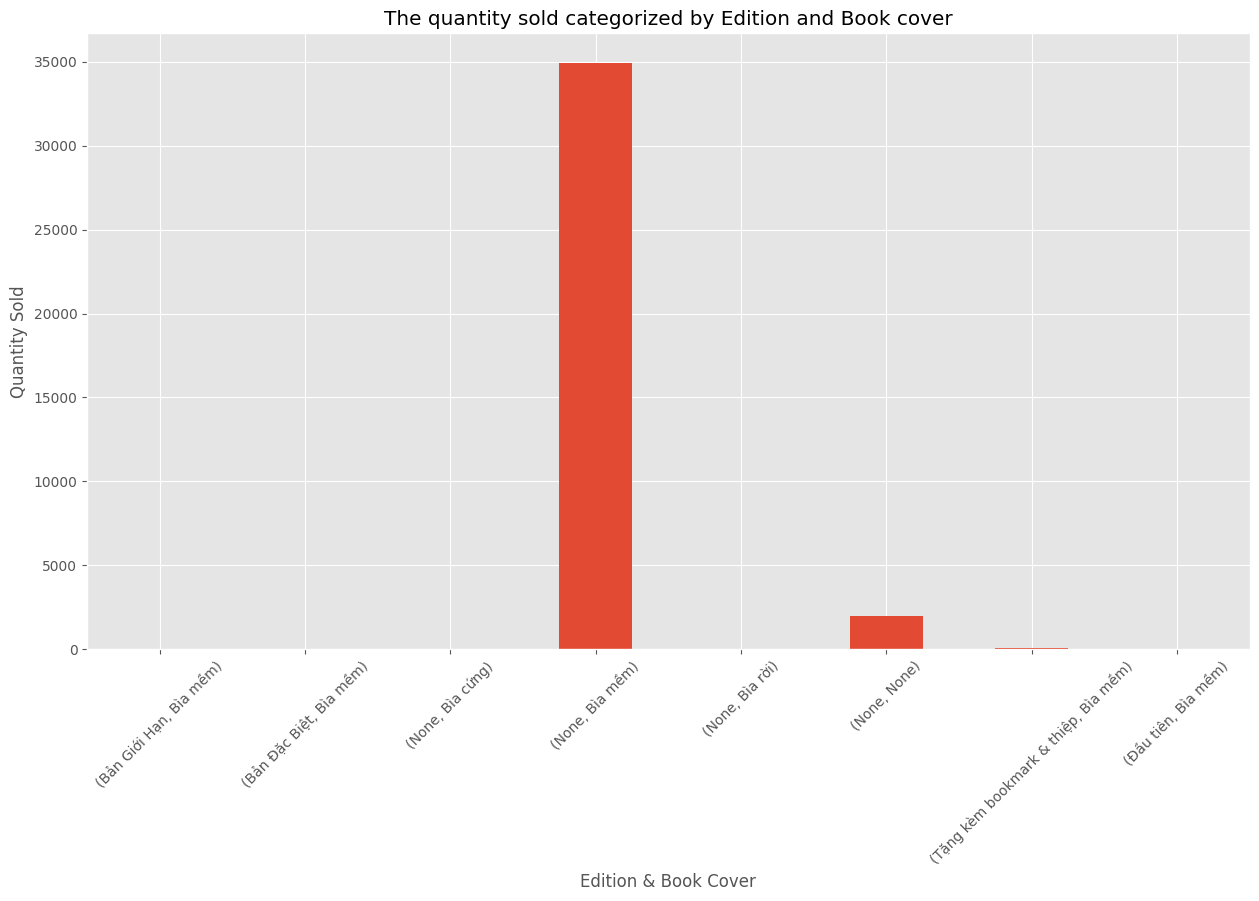

In [208]:
plot_df = new_df.groupby(['edition', 'book_cover'])['all_time_quantity_sold'].sum()
plot_df
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(15, 8))
ax = plot_df.plot(kind = 'bar', rot = 45)
ax.set_title('The quantity sold categorized by Edition and Book cover')
ax.set(xlabel = 'Edition & Book Cover', ylabel = 'Quantity Sold')


Hmm ta có thể thấy rõ rằng là mọi người mua thể loại `Light novel` này đa số là quan tâm bản thường và có loại bìa mềm, chiếm hơn thể loại bản thường và không có bìa

---

##### **Câu 4**

- Có phải khi sự đánh giá (`rating_average`) của 1 cuốn sách nào đó cao thì shop sẽ khuyến mãi ưu đãi nhiều (`discount_rate`) cho khách hàng?

**Trả lời câu hỏi thành công**

Tìm hiểu được về việc đánh giá của khách hàng có ảnh hưởng đến giảm giá của shop không? từ đó shop có thể có ra thêm các loại event sale hợp lý để tăng sự tin tưởng của khách hàng và lấy được thêm các rating cao

Vẫn tiếp tục với 1 thể loại sách để xem rõ ràng hơn về `discount_rate`, ta sẽ chọn thể loại `Light novel`

<font color=red>Khó khăn</font>:
- Quan sát toàn bộ số lượng sẽ dẫn đến chúng ta khó thấy sự khác biệt trong thay đổi tỉ lệ `discount_rate`. Ta sẽ số liệu thành thành sách dược bán vào năm 2021 và năm 2022.
- Ngoài ra, ta cũng sẽ tạo 1 khoảng mức ratings:

**(0,0)** ứng với 0 sao <br>
**(0,1)** ứng với (0,1) <br>
**(1,2)** ứng với [1,2) <br>
**(2,3)** ứng với [2,3) <br>
**(3,4)** ứng với [3,4) <br>
**(4,5)** ứng với [4,5) <br>
**(5,5)** ứng với 5 sao <br>

In [209]:
df_2021 = new_df.loc[(new_df['day_ago_created'] > 365) & (new_df['day_ago_created'] <= 730)]
df_2022 = new_df.loc[new_df['day_ago_created'] <= 365]

new_df_2021 = df_2021[['discount_rate', 'rating_average']]
new_df_2022 = df_2022[['discount_rate', 'rating_average']]

temp_df_2021 = pd.DataFrame({"rating_range": new_df_2021.rating_average.apply(rating_range)})
temp_df_2022 = pd.DataFrame({"rating_range": new_df_2022.rating_average.apply(rating_range)})

new_df_2021 = pd.concat([new_df_2021, temp_df_2021], axis= 1)
new_df_2022 = pd.concat([new_df_2022, temp_df_2022], axis= 1)


Ta sẽ trực quan hoá dữ liệu để tiện quan sát hơn

[Text(0.5, 0, 'Rating Range'), Text(0, 0.5, 'Discount Rate')]

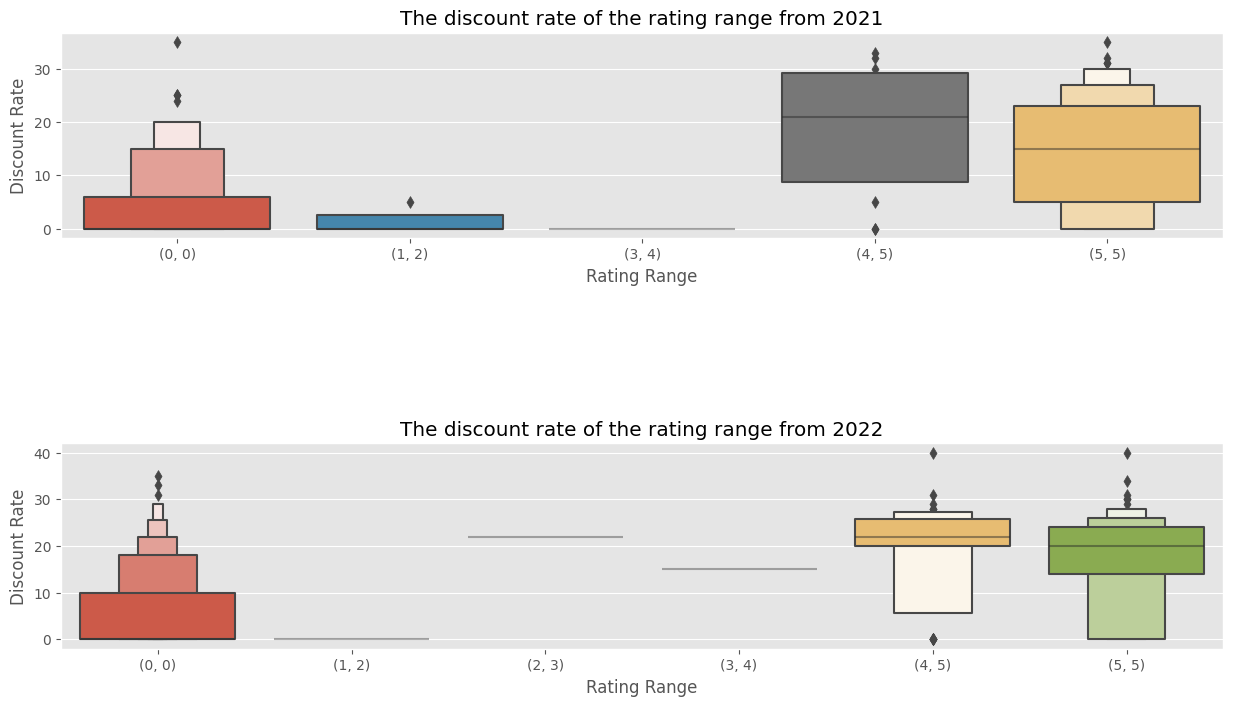

In [210]:
new_df_2021 = new_df_2021.sort_values('rating_range')
new_df_2022 = new_df_2022.sort_values('rating_range')

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(15, 8))
plt.subplots_adjust(hspace = 1)

sns.boxenplot(data = new_df_2021, x = 'rating_range', y = 'discount_rate', ax = axes[0])
axes[0].set_title('The discount rate of the rating range from 2021')
axes[0].set(xlabel = 'Rating Range', ylabel = 'Discount Rate')

sns.boxenplot(data = new_df_2022, x = 'rating_range', y = 'discount_rate', ax = axes[1])
axes[1].set_title('The discount rate of the rating range from 2022')
axes[1].set(xlabel = 'Rating Range', ylabel = 'Discount Rate')

 Ta cảm thấy xu hướng năm 2022 càng ngày càng rõ rệt hơn về mức giảm giá. Năm 2021 thì discount_rate còn trải dài đều từ 10% đến 30% vào những sản phẩm từ 4 sao đến 5 sao và những mặt hàng 0 sao thì chưa đa dạng về discount_rate. Vào năm 2022 thì các shop đã cho ra những mức discount_rate ở những sản phẩm 4 sao đến 5 sao càng rơi vào mức 15% đến 25% và những mặt hàng 0 sao thì đa dạng hơn về discount_rate. Qua đây thì ta dự đoán thêm về xu hướng năm 2023 chăng?



##### **Câu 5**

- Dự đoán giá của một sản phẩm sách dựa vào các đặc trưng: rating_average, review_count, inventory_type,..

**Trả lời câu hỏi thành công** <br>


---